In [251]:
import numpy as np 
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

sns.set_style('white')
mpl.rcParams['figure.figsize'] = (9, 6)
sns.set_context('talk', font_scale = 1)

# Import and Clean 

In [252]:
df = pd.read_csv('game_reviews.csv')

In [253]:
df.head()

,author age,recommended age,review
0,"Teen, 17 years old",age 7+,Kids dont listent to the parents saying ''ThIs GaMe HaS sWoRdS tHaT mEaNs ThErE iS vIoLaNcE'' there is no violance but its good to not play all day play like idk 2 hours.I think minecraft is a child friendly game and is open to all ages thats my opinion.
1,"Kid, 11 years old",age 2+,I have been playing this game for many years and I have never gotten scared or had nightmares about the monsters and “violence”. There is no blood or anything very gruesome. All you do is hit the animal/monster. From Minecraft I learned how to build great houses (not that great :( ) and it allows me and my brother to be creative and build.
2,"Kid, 12 years old",age 7+,The game is great with no true inappropriate things
3,"Teen, 13 years old",age 5+,Are you sure you got common sense. I would give this game 3 MILLION stars! 7 dollars isn't a lot of money!
4,"Kid, 10 years old",age 5+,IDK WHAT TO SAY BUT DIS IS DA BEST GAME EVA


In [254]:
df.dtypes

author age         object
recommended age    object
review             object
dtype: object

In [255]:
df['recommended age'].value_counts()

age 7+     99
age 6+     97
age 5+     80
age 2+     68
age 8+     66
age 4+     38
age 10+    30
age 3+     27
age 9+     20
age 18+    10
age 13+     8
age 11+     6
age 16+     4
age 14+     4
age 15+     2
age 17+     1
age 12+     1
Name: recommended age, dtype: int64

In [256]:
df['recommended age'].replace('[+age\s]', '', regex=True, inplace=True)

In [257]:
df['recommended age'].value_counts()

7     99
6     97
5     80
2     68
8     66
4     38
10    30
3     27
9     20
18    10
13     8
11     6
16     4
14     4
15     2
17     1
12     1
Name: recommended age, dtype: int64

In [258]:
df['recommended age'] = df['recommended age'].astype('int')

In [259]:
df.dtypes

author age         object
recommended age     int64
review             object
dtype: object

In [260]:
df['not_suitable_age_10'] = np.where(df['recommended age']>10, 1, 0)

In [261]:
df.head()

,author age,recommended age,review,not_suitable_age_10
0,"Teen, 17 years old",7,Kids dont listent to the parents saying ''ThIs GaMe HaS sWoRdS tHaT mEaNs ThErE iS vIoLaNcE'' there is no violance but its good to not play all day play like idk 2 hours.I think minecraft is a child friendly game and is open to all ages thats my opinion.,0
1,"Kid, 11 years old",2,I have been playing this game for many years and I have never gotten scared or had nightmares about the monsters and “violence”. There is no blood or anything very gruesome. All you do is hit the animal/monster. From Minecraft I learned how to build great houses (not that great :( ) and it allows me and my brother to be creative and build.,0
2,"Kid, 12 years old",7,The game is great with no true inappropriate things,0
3,"Teen, 13 years old",5,Are you sure you got common sense. I would give this game 3 MILLION stars! 7 dollars isn't a lot of money!,0
4,"Kid, 10 years old",5,IDK WHAT TO SAY BUT DIS IS DA BEST GAME EVA,0


# NLP Custom Functions

In [262]:
import gensim
from gensim.utils import simple_preprocess   # Convert a document into a list of lowercase tokens, ignoring tokens that are too short or too long.
from gensim.parsing.preprocessing import STOPWORDS

import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *


# our nlp pre-processing custom functions
stemmer = SnowballStemmer('english')
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))  # pos = "v" => only lemmatize verbs and leave nouns 'n' and adjectives 'a' alone

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS:
            result.append(lemmatize_stemming(token))
    return str(result)

In [263]:
df.isna().mean()

author age             0.000000
recommended age        0.000000
review                 0.062389
not_suitable_age_10    0.000000
dtype: float64

In [264]:
df.dropna(inplace = True)

In [265]:
df_nlp = df.copy()

# apply our custom function 'preprocess' on all rows of the 'description' column to create tokens
df_nlp['tokens'] = df_nlp['review'].map(preprocess)

In [266]:
df_nlp.head()

,author age,recommended age,review,not_suitable_age_10,tokens
0,"Teen, 17 years old",7,Kids dont listent to the parents saying ''ThIs GaMe HaS sWoRdS tHaT mEaNs ThErE iS vIoLaNcE'' there is no violance but its good to not play all day play like idk 2 hours.I think minecraft is a child friendly game and is open to all ages thats my opinion.,0,"['kid', 'dont', 'listent', 'parent', 'say', 'game', 'sword', 'mean', 'violanc', 'violanc', 'good', 'play', 'day', 'play', 'like', 'idk', 'hour', 'think', 'minecraft', 'child', 'friend', 'game', 'open', 'age', 'that', 'opinion']"
1,"Kid, 11 years old",2,I have been playing this game for many years and I have never gotten scared or had nightmares about the monsters and “violence”. There is no blood or anything very gruesome. All you do is hit the animal/monster. From Minecraft I learned how to build great houses (not that great :( ) and it allows me and my brother to be creative and build.,0,"['play', 'game', 'year', 'get', 'scar', 'nightmar', 'monster', 'violenc', 'blood', 'gruesom', 'hit', 'anim', 'monster', 'minecraft', 'learn', 'build', 'great', 'hous', 'great', 'allow', 'brother', 'creativ', 'build']"
2,"Kid, 12 years old",7,The game is great with no true inappropriate things,0,"['game', 'great', 'true', 'inappropri', 'thing']"
3,"Teen, 13 years old",5,Are you sure you got common sense. I would give this game 3 MILLION stars! 7 dollars isn't a lot of money!,0,"['sure', 'get', 'common', 'sens', 'game', 'million', 'star', 'dollar', 'isn', 'lot', 'money']"
4,"Kid, 10 years old",5,IDK WHAT TO SAY BUT DIS IS DA BEST GAME EVA,0,"['idk', 'dis', 'da', 'best', 'game', 'eva']"


In [267]:
np.round(df['not_suitable_age_10'].value_counts(normalize = True)*100)

0    95.0
1     5.0
Name: not_suitable_age_10, dtype: float64

> <span style="color:SteelBlue"> We can see that there is a severe class imbalance in our target, i.e. only 5% of the data is in class 1. This means  that we need to do random resampling before our modeling. However, "Random Undersampling + SMOTE" requires numerical features. So, we first encode "tokens" column using tfidf_vectorizer, and then do the resampling.


In [437]:
# Create two DFs: one for cross validation with resampling, one for Test with no resampling
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split

cross_val_df, test_df = train_test_split(df_nlp, test_size=0.33)

print(f'cross_val_df:\n{cross_val_df["not_suitable_age_10"].value_counts(normalize=True)*100}')
print()
print(f'test_df:\n{test_df["not_suitable_age_10"].value_counts(normalize=True)*100}')

cross_val_df:
0    95.454545
1     4.545455
Name: not_suitable_age_10, dtype: float64

test_df:
0    94.252874
1     5.747126
Name: not_suitable_age_10, dtype: float64


In [438]:
cross_val_df.shape, test_df.shape

((352, 5), (174, 5))

In [439]:
X_cv = cross_val_df['tokens']
y_cv = cross_val_df['not_suitable_age_10']

X_test = test_df['tokens']
y_test = test_df['not_suitable_age_10']

In [440]:
X_cv

271                   ['game', 'fun', 'gamm', 'favorit']
507    ['play', 'pc', 'pe', 'pe', 'probabl', 'easiest...
296    ['final', 'build', 'want', 'reason', 'give', '...
291    ['good', 'older', 'kid', 'violenc', 'gore', 'b...
391    ['play', 'minecraft', 'mobil', 'edit', 'come',...
                             ...                        
167    ['thing', 'think', 'inappropri', 'sword', 'bow...
449    ['mom', 'buy', 'ipad', 'birthday', 'year', 'us...
473    ['minecraft', 'awesom', 'game', 'tri', 'build'...
105    ['esrb', 'suck', 'year', 'old', 'play', 'minec...
284    ['thorough', 'enjoy', 'game', 'infinit', 'poss...
Name: tokens, Length: 352, dtype: object

In [441]:
y_cv.reset_index(drop=True)

0      0
1      0
2      0
3      0
4      0
      ..
347    0
348    0
349    0
350    0
351    0
Name: not_suitable_age_10, Length: 352, dtype: int64

In [442]:
# Initialize tf-idf vectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(stop_words='english',
#                                    max_df=0.9,
#                                    min_df=0.05,
                                   max_features = 80)   # we need t0 have the same number of features in cv and test

# Create tf-idf (encodes tokens)
X_test_tfidf = tfidf_vectorizer.fit_transform(X_test)
X_cv_tfidf = tfidf_vectorizer.fit_transform(X_cv)

In [443]:
X_cv_tfidf.shape, X_test_tfidf.shape

((352, 80), (174, 80))

In [444]:
# list of features for X_cv_tfidf
print(len(tfidf_vectorizer.get_feature_names()))

tfidf_vectorizer.get_feature_names()

80


['age',
 'amaz',
 'anim',
 'bad',
 'best',
 'better',
 'block',
 'blood',
 'build',
 'buy',
 'chat',
 'child',
 'children',
 'cool',
 'craft',
 'creativ',
 'die',
 'dont',
 'easi',
 'edit',
 'educ',
 'end',
 'fight',
 'food',
 'friend',
 'fun',
 'game',
 'good',
 'great',
 'hit',
 'hous',
 'inappropri',
 'join',
 'kid',
 'kill',
 'know',
 'learn',
 'let',
 'like',
 'littl',
 'lot',
 'love',
 'minecraft',
 'mob',
 'mode',
 'monster',
 'multiplay',
 'need',
 'old',
 'onlin',
 'parent',
 'pc',
 'peopl',
 'play',
 'player',
 'pretti',
 'real',
 'recommend',
 'review',
 'scari',
 'server',
 'start',
 'stuff',
 'surviv',
 'thing',
 'think',
 'time',
 'tri',
 'turn',
 'understand',
 'updat',
 'use',
 'version',
 'violenc',
 'violent',
 'want',
 'way',
 'world',
 'year',
 'zombi']

- **Random Undersampling + SMOTE**
> <span style="color:SteelBlue"> We first need to oversample the minority class using `SMOTE (Synthetic Minority Oversampling Technique)` to have 10 percent the number of examples of the majority class (1:10), then use random undersampling to reduce the number of examples in the majority class to have 50 percent more than the minority class (1:2). This will give us an overall class imbalance of 1:3.

    > <span style="color:SteelBlue"> The change to the class distribution should only be applied to the training dataset. The intent is to influence the fit of the models. The resampling is not applied to the test dataset. This is why, we create two DataFrames below: `cross_val_df` for cross validation with resampling, and `test_df` (with no resampling) for testing our model. **The test_df is therefore going to be our holdout test dataset.** This process is shown in the diagram below.

In [445]:
# For resamplingm, we first need to concatinate X_cv_tfidf and y_cv
X_cv_tfidf.shape, y_cv.shape

((352, 80), (352,))

In [446]:
pd.DataFrame(X_cv_tfidf.toarray())

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.000000
1,0.0,0.0,0.000000,0.000000,0.203862,0.0,0.0,0.0,0.000000,0.000000,...,0.210060,0.000000,0.000000,0.000000,0.0,0.154015,0.21006,0.0,0.000000,0.000000
2,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.377881,0.000000,...,0.000000,0.000000,0.000000,0.422839,0.0,0.429727,0.00000,0.0,0.000000,0.000000
3,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.484264,0.000000,...,0.000000,0.000000,0.000000,0.541878,0.0,0.000000,0.00000,0.0,0.000000,0.000000
4,0.0,0.0,0.000000,0.170358,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.000000
348,0.0,0.0,0.000000,0.095825,0.000000,0.0,0.0,0.0,0.069424,0.209001,...,0.000000,0.101626,0.000000,0.000000,0.0,0.078949,0.00000,0.0,0.092273,0.209001
349,0.0,0.0,0.138124,0.000000,0.000000,0.0,0.0,0.0,0.222429,0.000000,...,0.172496,0.000000,0.165822,0.124446,0.0,0.126473,0.00000,0.0,0.000000,0.000000
350,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.575234,0.000000


In [447]:
y_cv

271    0
507    0
296    0
291    0
391    0
      ..
167    0
449    0
473    0
105    0
284    0
Name: not_suitable_age_10, Length: 352, dtype: int64

In [448]:
df_resamp = pd.concat([pd.DataFrame(X_cv_tfidf.toarray()), y_cv.reset_index(drop=True)], axis = 1)
df_resamp

,0,1,2,3,4,5,6,7,8,9,...,71,72,73,74,75,76,77,78,79,not_suitable_age_10
0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0
1,0.0,0.0,0.000000,0.000000,0.203862,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.154015,0.21006,0.0,0.000000,0.000000,0
2,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.377881,0.000000,...,0.000000,0.000000,0.422839,0.0,0.429727,0.00000,0.0,0.000000,0.000000,0
3,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.484264,0.000000,...,0.000000,0.000000,0.541878,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0
4,0.0,0.0,0.000000,0.170358,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.000000,0
348,0.0,0.0,0.000000,0.095825,0.000000,0.0,0.0,0.0,0.069424,0.209001,...,0.101626,0.000000,0.000000,0.0,0.078949,0.00000,0.0,0.092273,0.209001,0
349,0.0,0.0,0.138124,0.000000,0.000000,0.0,0.0,0.0,0.222429,0.000000,...,0.000000,0.165822,0.124446,0.0,0.126473,0.00000,0.0,0.000000,0.000000,0
350,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.575234,0.000000,0


In [449]:
def RandomUnderSampler_SMOTE(df):
    '''>>> returns resampled X and y using a combination of Random Undersampling & SMOTE
       >>> X: Independent variables as a DataFrame;
       >>> y: Dependent variable as a Series 
    '''
    
    import imblearn
    from imblearn.over_sampling import SMOTE
    from imblearn.under_sampling import RandomUnderSampler
    from imblearn.pipeline import Pipeline
    
    y = df.not_suitable_age_10
    X = df[df.columns[~df.columns.isin(['not_suitable_age_10'])]]
    
    # define pipeline
    over = SMOTE(k_neighbors=5, sampling_strategy=0.1)
    under = RandomUnderSampler(sampling_strategy=0.5)
    steps = [('o', over), ('u', under)]
    pipeline = Pipeline(steps=steps)
    
    # transform the dataset
    X, y = pipeline.fit_resample(X, y)
    
    return X, y

In [450]:
X, y = RandomUnderSampler_SMOTE(df_resamp)

In [451]:
# class imbalance
print(f"== New Class Imbalance (Ratio) in cross_val_df == \n{y.value_counts(normalize = True).round(4)*100}\n")

== New Class Imbalance (Ratio) in cross_val_df == 
0    66.67
1    33.33
Name: not_suitable_age_10, dtype: float64



In [452]:
X

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,0.000000,0.120178,0.0,0.109134,0.119014,0.0,0.0,0.000000,0.158132,0.000000,...,0.0,0.000000,0.0,0.000000,0.122633,0.000000,0.0,0.000000,0.000000,0.0
1,0.000000,0.000000,0.0,0.000000,0.180916,0.0,0.0,0.000000,0.360569,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
2,0.365668,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
3,0.211155,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.221558,0.000000,0.000000,...,0.0,0.000000,0.0,0.173848,0.000000,0.000000,0.0,0.000000,0.000000,0.0
4,0.000000,0.000000,0.0,0.439402,0.000000,0.0,0.0,0.226986,0.000000,0.239592,...,0.0,0.233002,0.0,0.356215,0.000000,0.000000,0.0,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.444683,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.505694,0.0,0.639584,0.000000,0.0
95,0.000000,0.000000,0.0,0.008260,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.008760,0.0,0.003348,0.009281,0.000000,0.0,0.008607,0.003977,0.0
96,0.000000,0.237395,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.457258,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
97,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0


In [453]:
y

0     0
1     0
2     0
3     0
4     0
     ..
94    1
95    1
96    1
97    1
98    1
Name: not_suitable_age_10, Length: 99, dtype: int64

#  XGBoost (XGB) with CV

In [462]:
# XGBoost
from xgboost import XGBClassifier

params = {
    "learning_rate": np.arange(0.05, 0.5, 0.05),         # eta = [default = 0.3]
    "subsample": np.arange(0.5, 1.0, 0.1),               # 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees
    "min_child_weight": np.arange(0.05, 0.5, 0.05),      # [default = 1]: Higher values prevent a model from learning relations which might be specific to the particular sample selected for a tree
    "colsample_bytree": [0.5, 0.75, 1.00],               # [default = 1]: Fraction of columns to be subsampled
    "max_depth": [2, 3, 6, 8, 10, 12],                   # [default = 6]: nb of tree levels
    "reg_lambda": [1.0, 1.25, 1.75, 2.0],                # [default = 1]: lambda > 0 prevents overfitting, acts like Learning Rate, does Pruning even if gamma = 0
    "gamma": np.arange(0.0, 40.0, 0.1),                  # pruning parameter
}

xgb_clf = XGBClassifier()
xgb_clf_cv = RandomizedSearchCV(estimator=xgb_clf,
                                cv=3,
                                param_distributions=params,
                                scoring='f1_macro')
xgb_clf_cv.fit(X, y)

[19:05:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:05:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:05:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:05:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints...
       37.4, 37.5, 37.6, 37.7, 37.8, 37.9, 38. , 38.1, 38.2, 38.3, 38.4,
       38.5, 38.6, 38.7, 38.8, 38.9, 39. , 39.1, 39.2, 39.3, 39.4, 39.5,
       39.6, 39.7, 39.8, 39.9]),
  

In [463]:
print(xgb_clf_cv.best_params_)
print(xgb_clf_cv.best_score_)

{'subsample': 0.5, 'reg_lambda': 2.0, 'min_child_weight': 0.1, 'max_depth': 8, 'learning_rate': 0.35000000000000003, 'gamma': 0.5, 'colsample_bytree': 0.5}
0.5972453778145198


In [464]:
# check test dataset
from sklearn.metrics import f1_score
round(f1_score(y_test, xgb_clf_cv.predict(X_test_tfidf)), 4)

0.2381

In [465]:
from sklearn.metrics import classification_report
print('=== XGB classification_report on TEST dataset ===')
print(classification_report(y_test, xgb_clf_cv.predict(X_test_tfidf), digits=6))

=== XGB classification_report on TEST dataset ===
              precision    recall  f1-score   support

           0   0.964789  0.835366  0.895425       164
           1   0.156250  0.500000  0.238095        10

    accuracy                       0.816092       174
   macro avg   0.560519  0.667683  0.566760       174
weighted avg   0.918321  0.816092  0.857647       174



> Very low Precision for class 1 (0.156) with macro avg f1-score of 0.567.

## ROC

In [466]:
# ROC data to a DataFrame
from sklearn.metrics import roc_curve

models = ['xgb_clf_cv']
roc = pd.DataFrame()

for m in models:
    y_pred_proba_test = locals()[m].predict_proba(X_test_tfidf)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_test)
    roc = pd.concat([
        roc,
        pd.DataFrame({
            f'FPR(Fall-out)_{m}': fpr,
            f'TPRate(Recall)_{m}': tpr,
            f'Threshold_{m}': thresholds
        })
    ],
              axis=1)

roc.drop(roc.columns[roc.columns.str.contains('Threshold')], axis = 1, inplace = True)
roc

,FPR(Fall-out)_xgb_clf_cv,TPRate(Recall)_xgb_clf_cv
0,0.000000,0.0
1,0.006098,0.0
2,0.060976,0.0
3,0.085366,0.4
4,0.164634,0.4
...,...,...
20,0.768293,0.8
21,0.774390,0.9
22,0.890244,0.9
23,0.890244,1.0


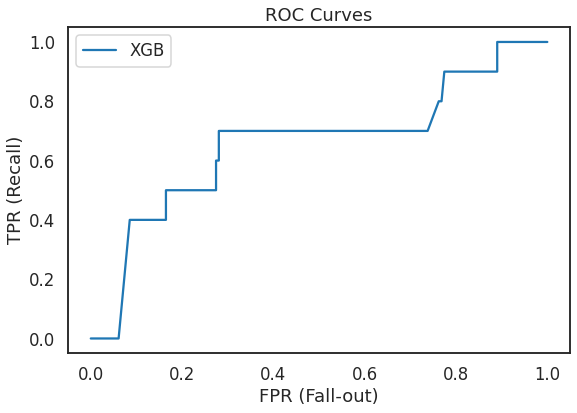

In [467]:
# comparing ROC curves
mpl.rcParams['figure.figsize'] = (9, 6)
sns.set_context('talk', font_scale = 1)

plt.plot(roc['FPR(Fall-out)_xgb_clf_cv'], roc['TPRate(Recall)_xgb_clf_cv'], label = 'XGB')

plt.xlabel("FPR (Fall-out)")
plt.ylabel("TPR (Recall)")
plt.title('ROC Curves')
plt.legend(loc = 'best')
plt.show()

## Precision-Recall Curve

In [470]:
# Precision-Recall data to a DataFrame
from sklearn.metrics import precision_recall_curve

models = ['xgb_clf_cv']
pr = pd.DataFrame()

for m in models:
    y_pred_proba_test = locals()[m].predict_proba(X_test_tfidf)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_test)
    pr = pd.concat([
        pr,
        pd.DataFrame({
            f'Precision_{m}': precision,
            f'Recall_{m}': recall
        })
    ],
                   axis=1)

pr.drop(pr.columns[pr.columns.str.contains('Threshold')], axis=1, inplace=True)
pr

,Precision_xgb_clf_cv,Recall_xgb_clf_cv
0,0.064103,1.0
1,0.058065,0.9
2,0.058442,0.9
3,0.058824,0.9
4,0.059211,0.9
...,...,...
135,0.000000,0.0
136,0.000000,0.0
137,0.000000,0.0
138,0.000000,0.0


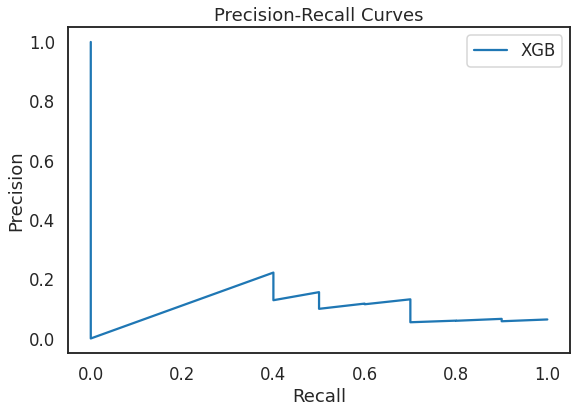

In [471]:
# comparing PR curves
mpl.rcParams['figure.figsize'] = (9, 6)
sns.set_context('talk', font_scale = 1)

plt.plot(pr['Recall_xgb_clf_cv'], pr['Precision_xgb_clf_cv'], label = 'XGB')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title('Precision-Recall Curves')
plt.legend(loc = 'best')
plt.show()

> Both ROC and PR curves show a model that is not very skillful, most probably due to low number of observations for calss 1.